In [ ]:
import pandas as pd
import os
os.environ["CORENLP_HOME"] = '/home/lcl/corenlp'
import pickle
from gensim.models import Word2Vec
from fuzzywuzzy import fuzz
from scipy import spatial
import numpy as np
from collections import Counter  
import re
import sys
import stanza.protobuf.CoreNLP_pb2 as CoreNLP_pb2
sys.modules['CoreNLP_pb2'] = CoreNLP_pb2
from ast import literal_eval
from collections import Counter
import functools
import itertools
import matplotlib.pyplot as plt
import glob
import networkx as nx
import cdlib
from cdlib import algorithms
articles = pd.read_csv('../cluster/blogs_clusterd_title_head_tail.csv', index_col='id')

In [ ]:
def extract_subgraph(g, nodes):
    sg = g.subgraph(nodes)
    sg_tactics = set()
    sg_articles = set()
    sg_linking_nodes = set()
    
    edge_labels = {}
    edge_mentions = []
    node2article = dict()
    for edge in sg.edges(data=True):
        mentions = edge[2]['mentions']
        sg_articles.update(map(lambda x: x.article_id, mentions))
        for mention in mentions:
            for tac in mention.tactic:
                sg_tactics.add(tac)
        if edge[0] not in node2article:
            node2article[edge[0]] = set()
        node2article[edge[0]].update(map(lambda x: x.article_id, mentions))
        if edge[1] not in node2article:
            node2article[edge[1]] = set()
        node2article[edge[1]].update(map(lambda x: x.article_id, mentions))
        
    for k, v in node2article.items():
        if len(v)>1:
            sg_linking_nodes.add(k)
            
    return sg, sg_tactics, sg_articles, sg_linking_nodes

def draw_graph(g, scheme=False, legend=False):
    node_deg = nx.degree(g)
    layout = nx.spring_layout(g, k=2, iterations=80)
    plt.figure(num=None, figsize=(20, 10), dpi=80)

    if scheme:
        node_labels = {node[0] : f"{node[0]}" for node in g.nodes(data=True)}
    else:
        node_labels = {node[0] : f"{node[0]}\n({node[1]['ent']})" for node in g.nodes(data=True)}
    nx.draw_networkx(
        g,
        node_size=[int(deg[1]) * 1000 for deg in node_deg],
        arrowsize=10,
        linewidths=1.5,
        pos=layout,
        edge_color='red',
        node_shape="s",
        bbox=dict(facecolor="skyblue", edgecolor='black', boxstyle='round,pad=0.1'),
        node_color='white',
        font_size=13,
        with_labels=True,
        labels = node_labels,
        )

    edge_labels = {}
    edge_mentions = []
    for edge in g.edges(data=True):
        mentions = edge[2]['mentions']
        mention_articles = ','.join(map(lambda x: str(x.article_id), mentions))
        mention_tactics = set()
        for mention in mentions:
            if len(mention.tactic)>0:
                for tac in mention.tactic: 
                    mention_tactics.add(tactic_dic[tac])
        mention_tactics = '('+','.join(mention_tactics)+')'
        
        edge_labels[(edge[0], edge[1])] = '-'.join([mention_tactics, edge[2]['relation'], mention_articles])
        edge_mentions.append(mentions)
    edge_mentions = [item for sublist in edge_mentions for item in sublist]
    descriptions = set([x.article_id for x in edge_mentions])
    
    texts = ['::'.join([str(x), articles.loc[x]['title'], articles.loc[x]['date']]) for x in descriptions]
    nx.draw_networkx_edge_labels(g, 
                                 pos=layout, 
                                 edge_labels=edge_labels,
                                 font_color='red',
                                 font_size=12)
    if legend:
        plt.legend(texts, fontsize=10)

In [129]:
kg = pickle.load(open('kg.pkl', 'rb'))

# Entity Behavior Discovery

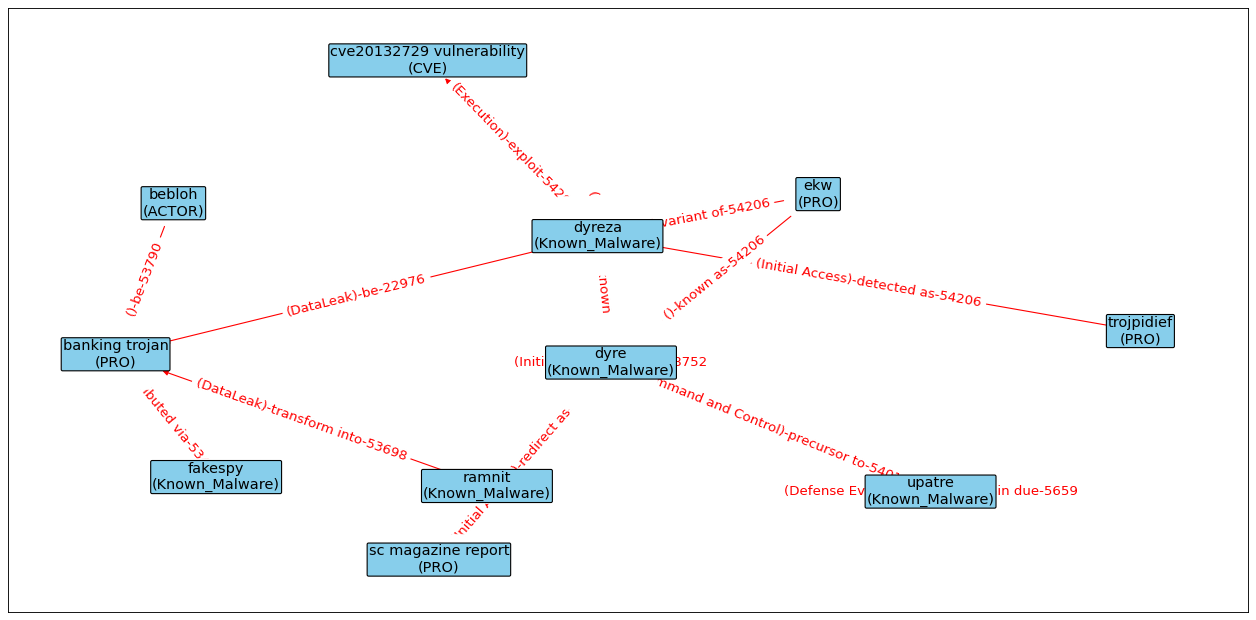

In [77]:
query = nx.bfs_tree(kg.to_undirected(), 'cve20132729 vulnerability', depth_limit=3)
sub, _, _, _ = extract_subgraph(kg, query.nodes)
draw_graph(sub)

# Community Detection

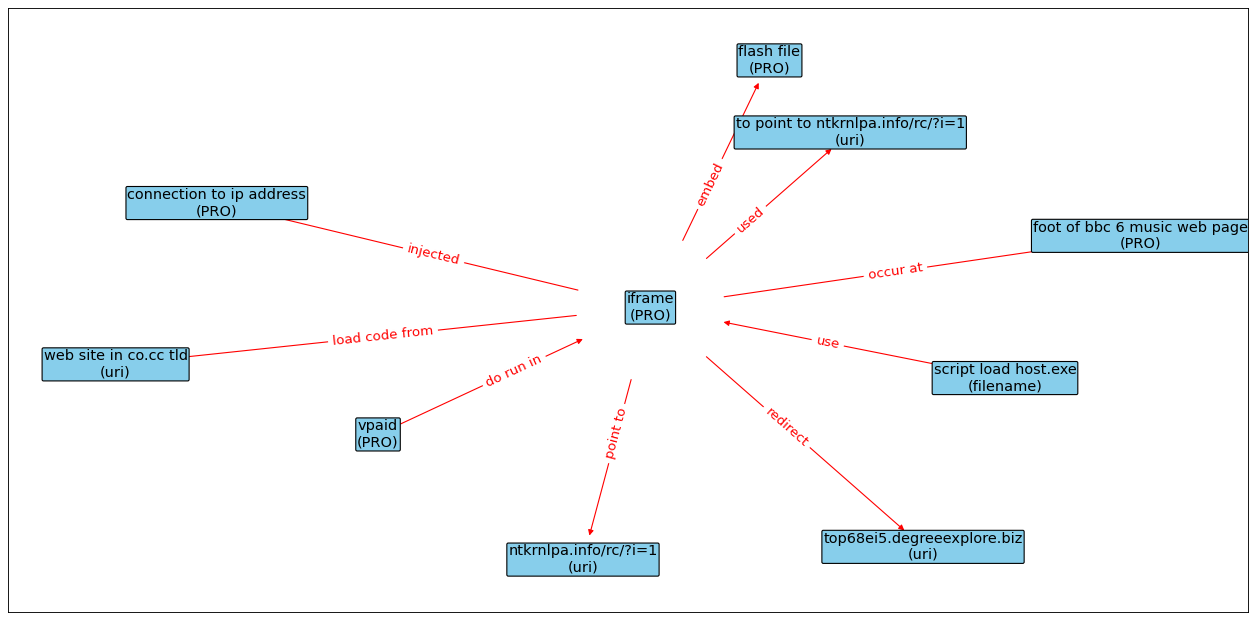

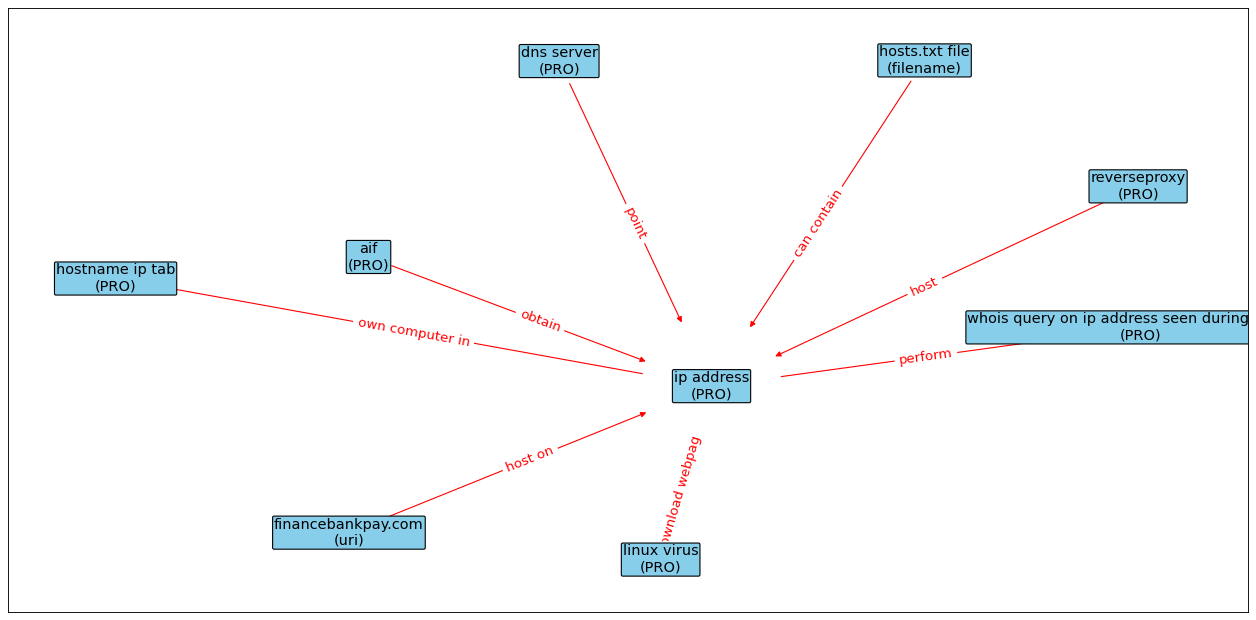

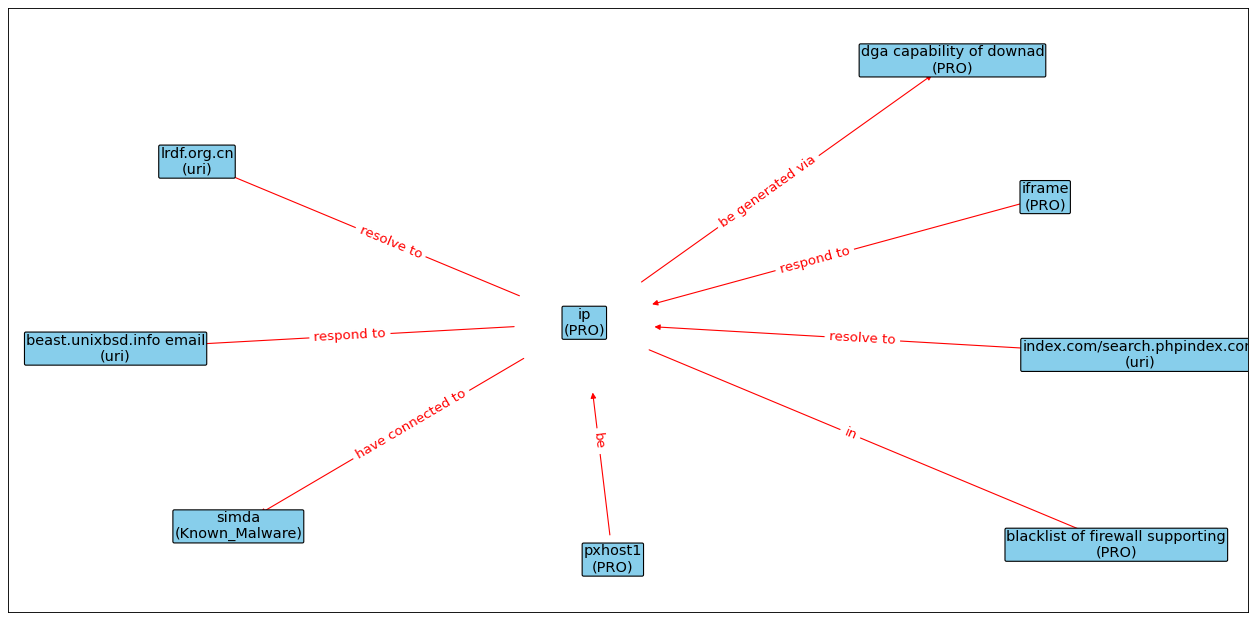

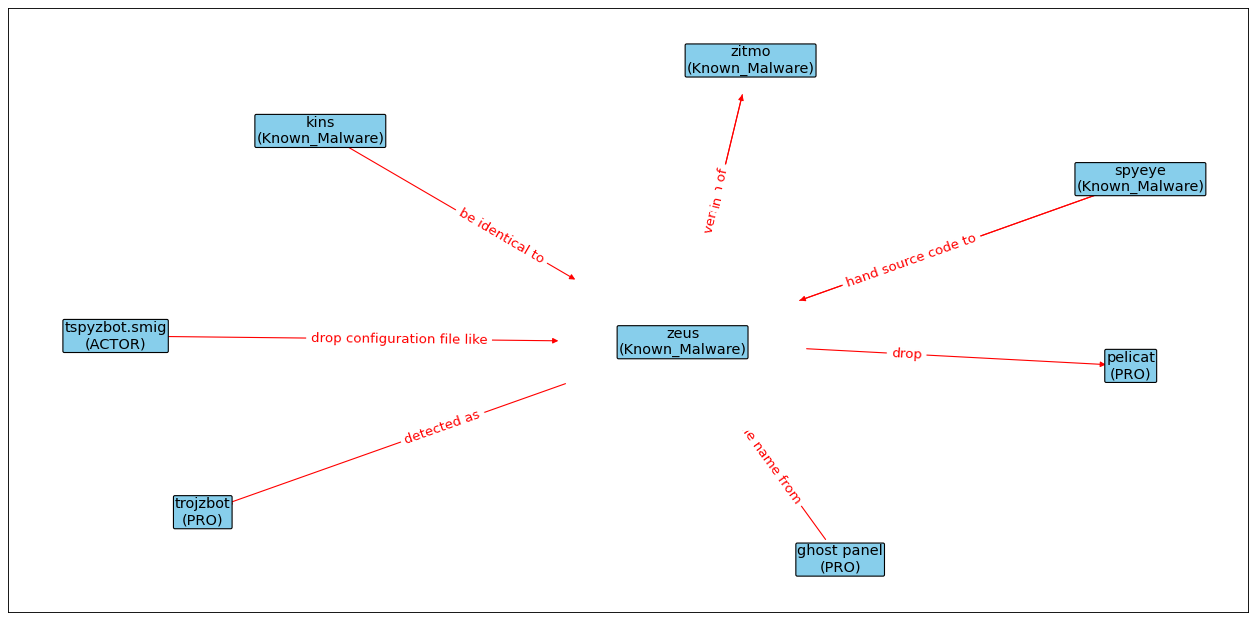

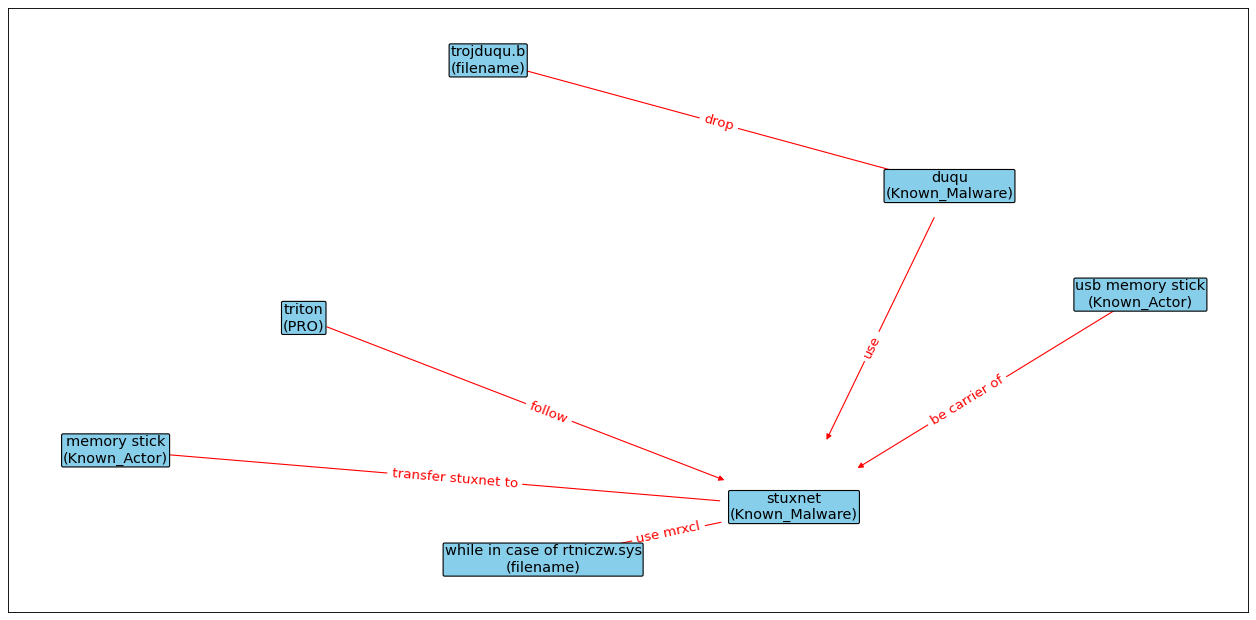

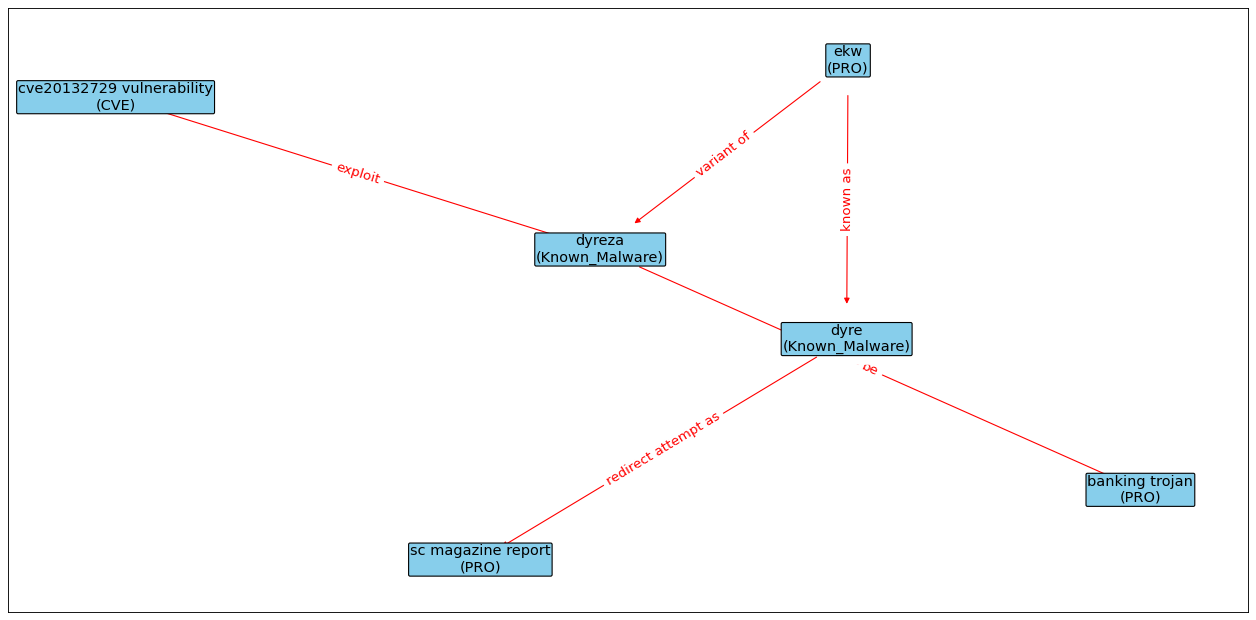

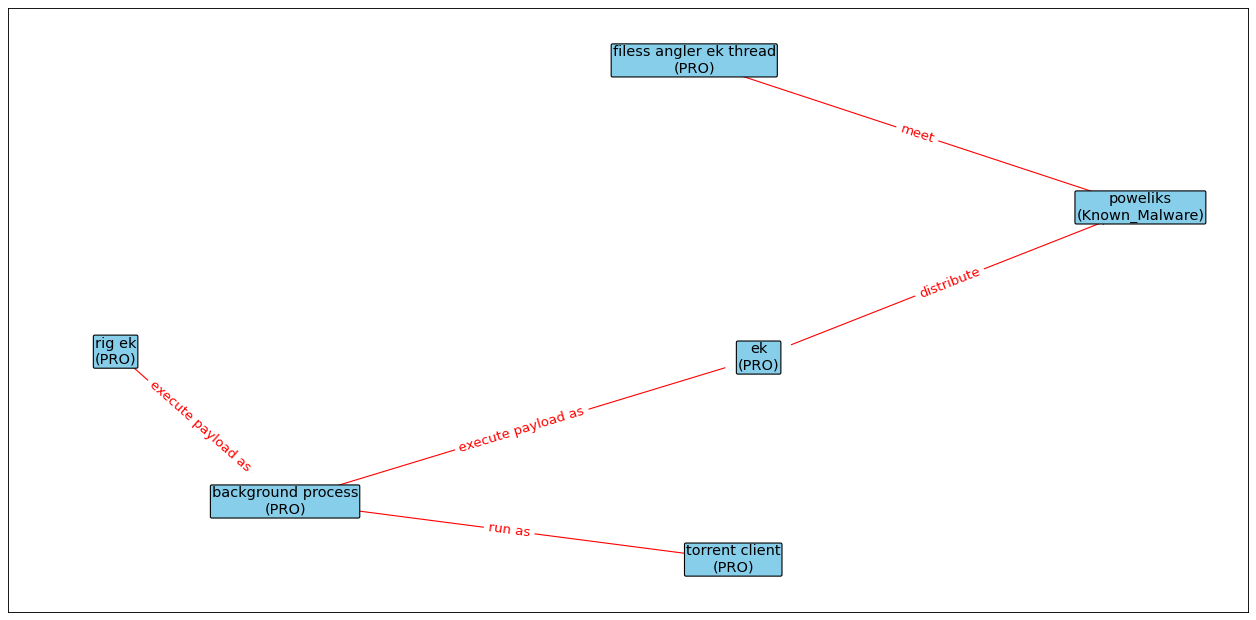

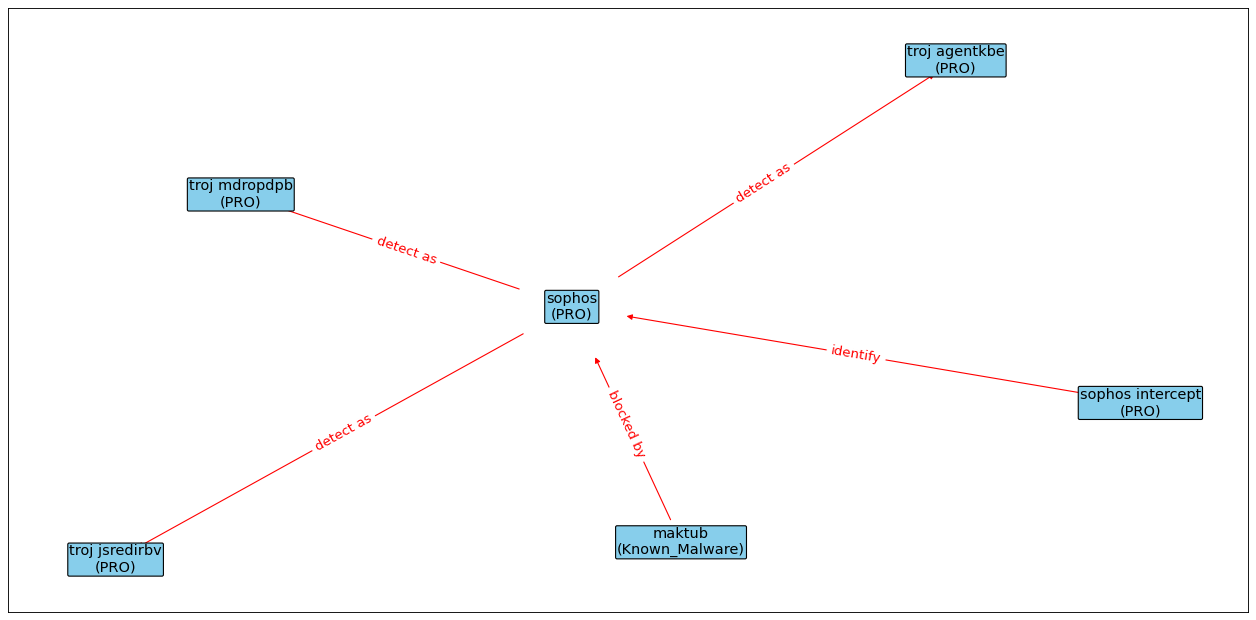

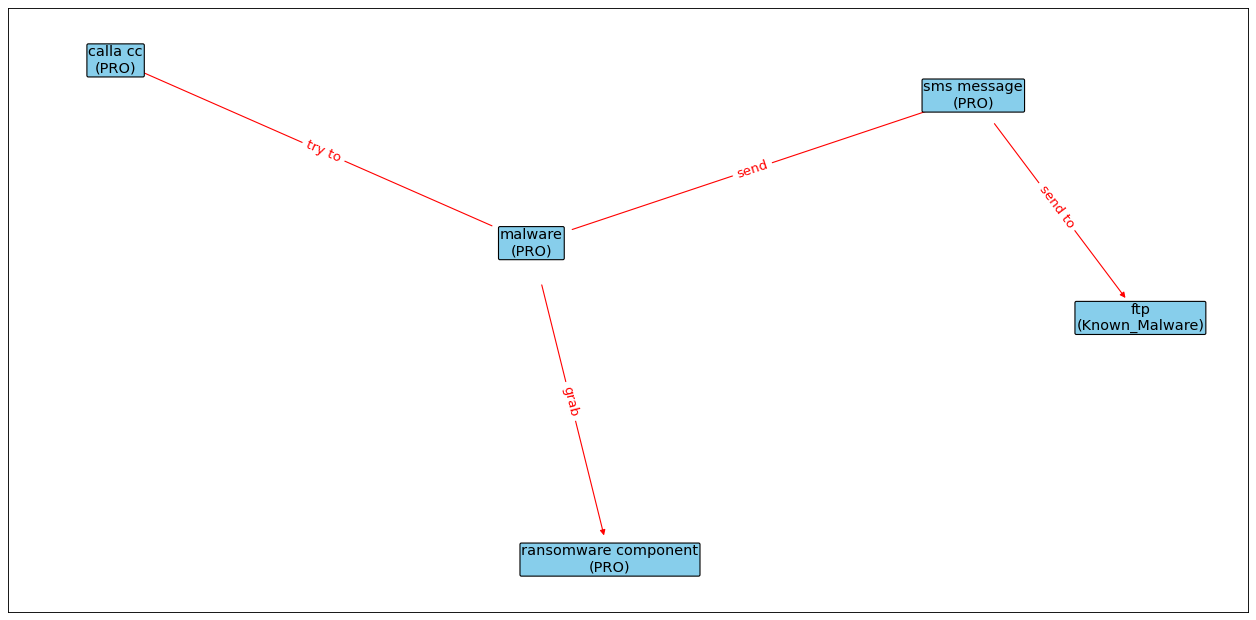

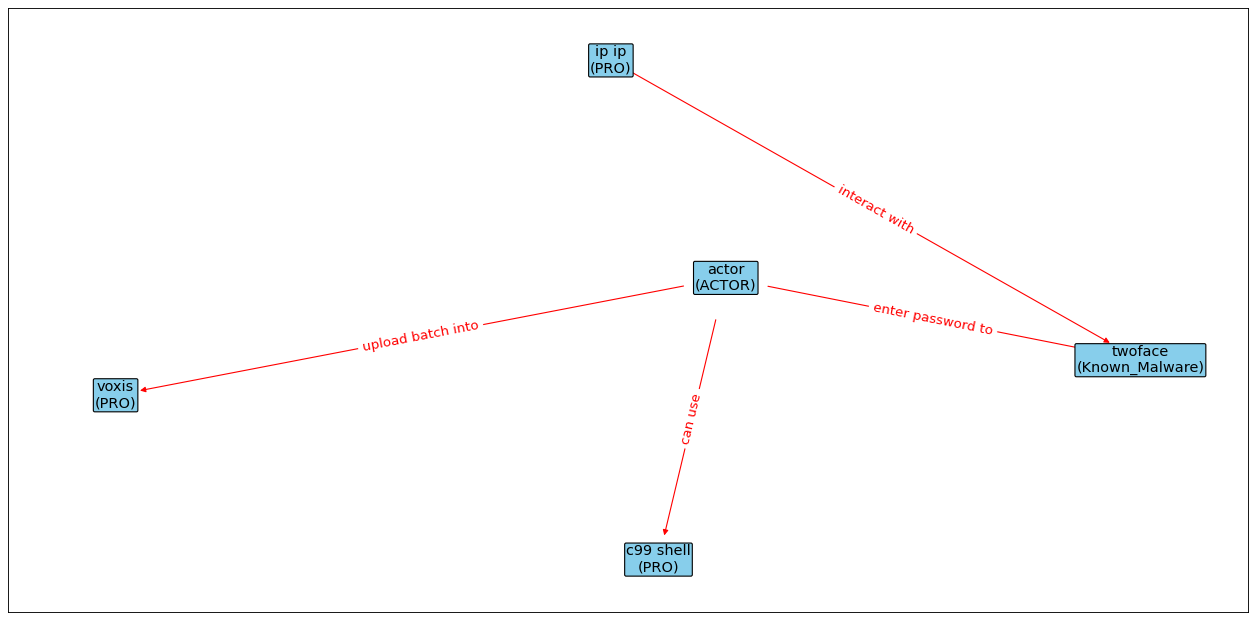

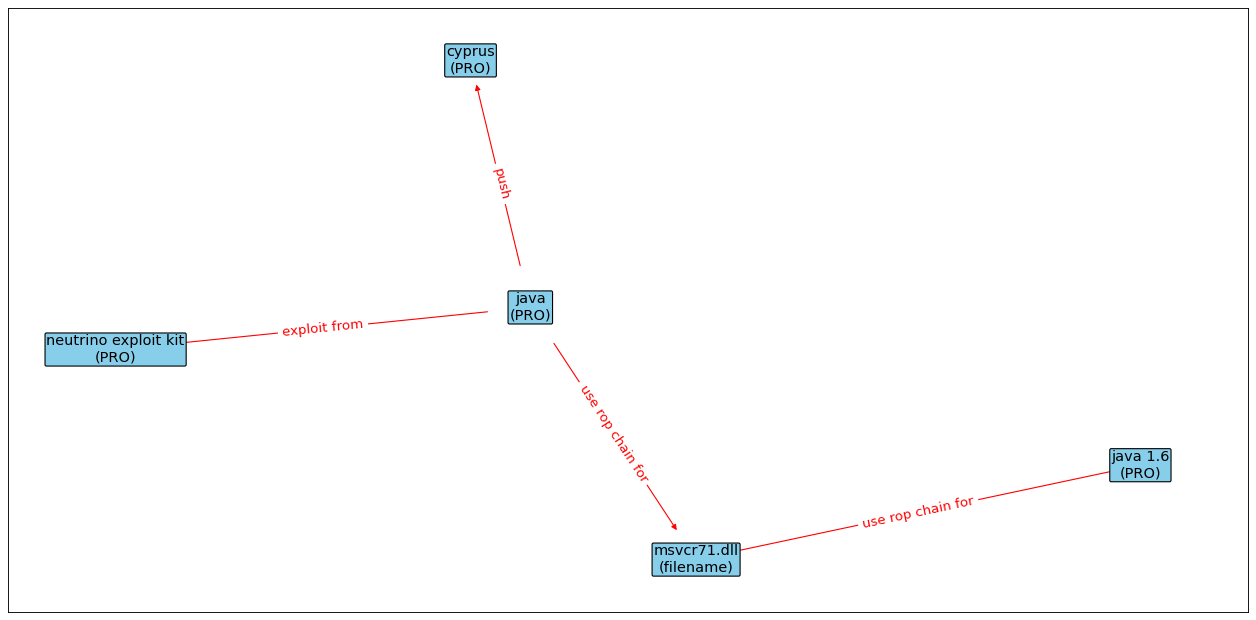

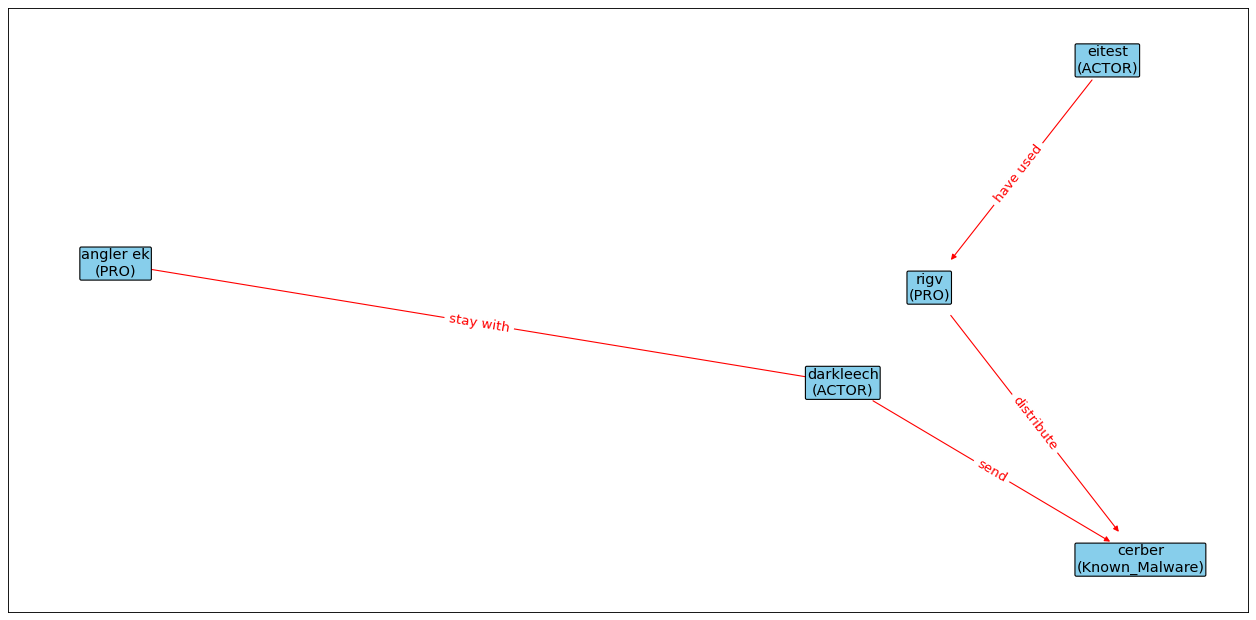

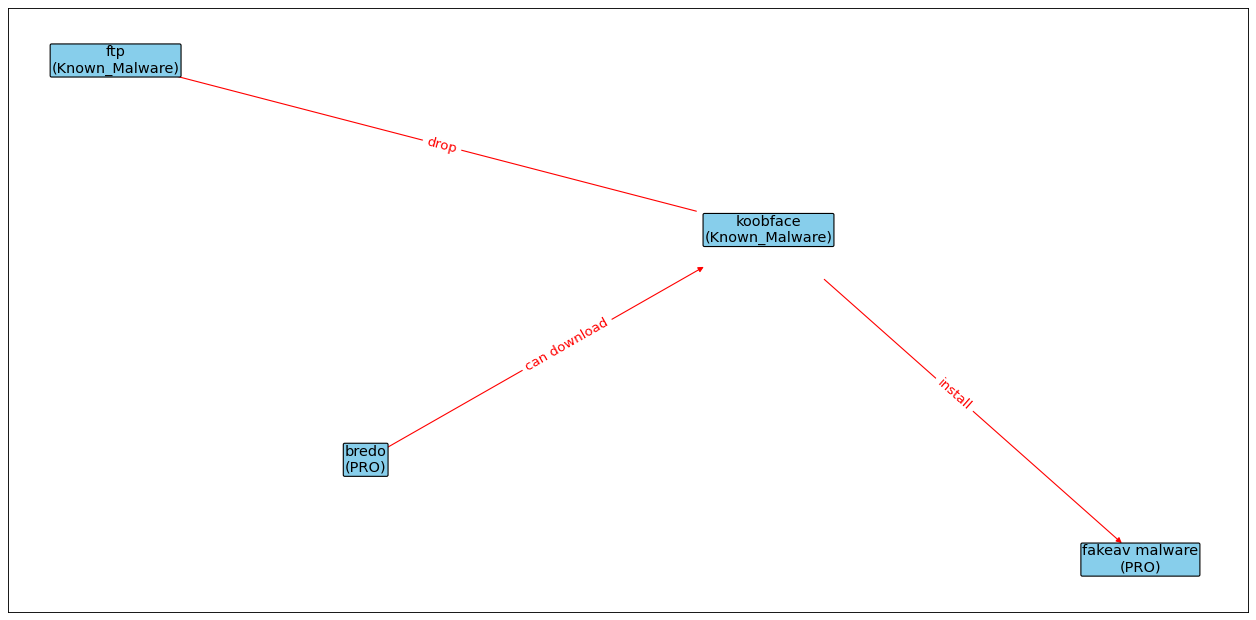

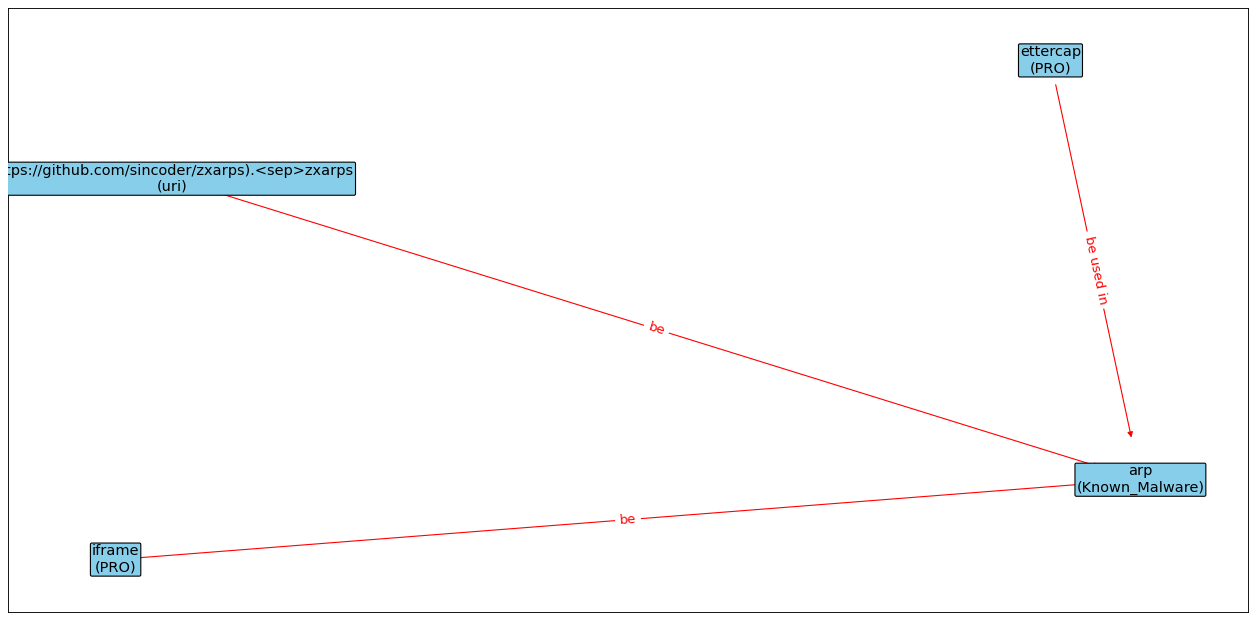

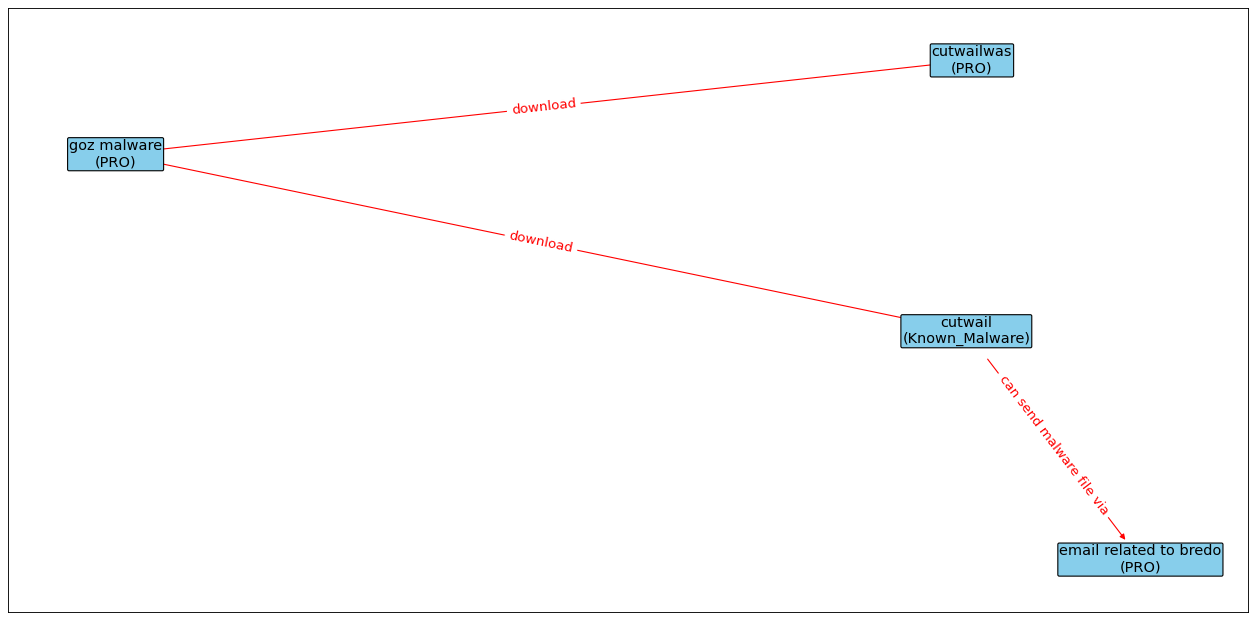

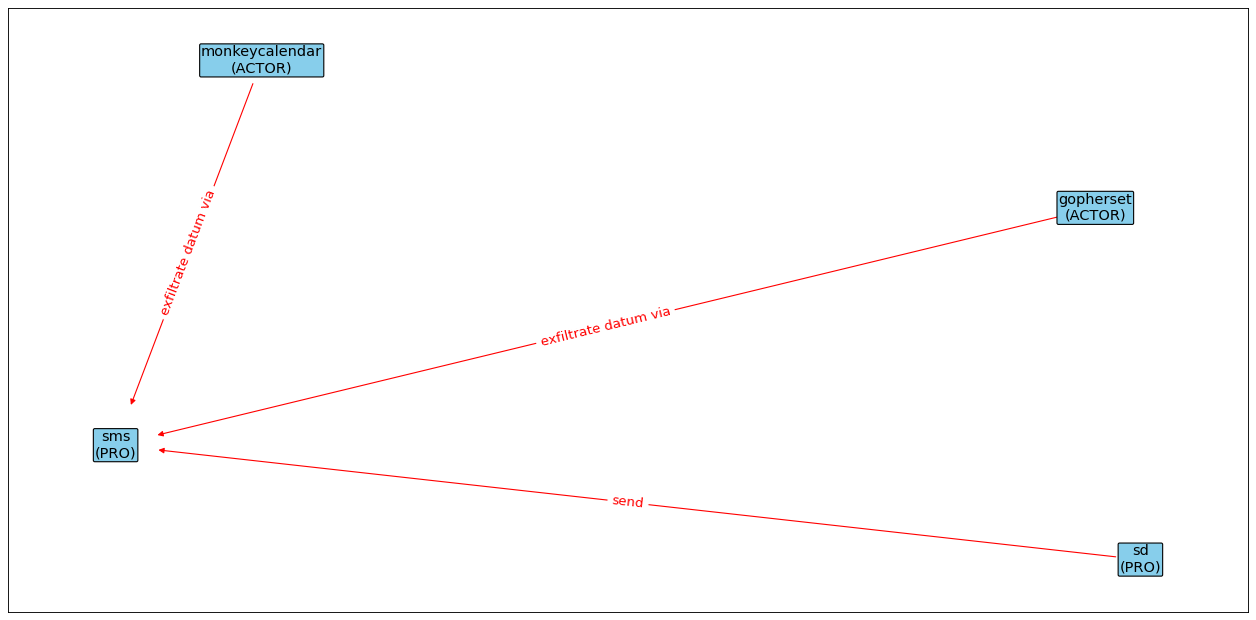

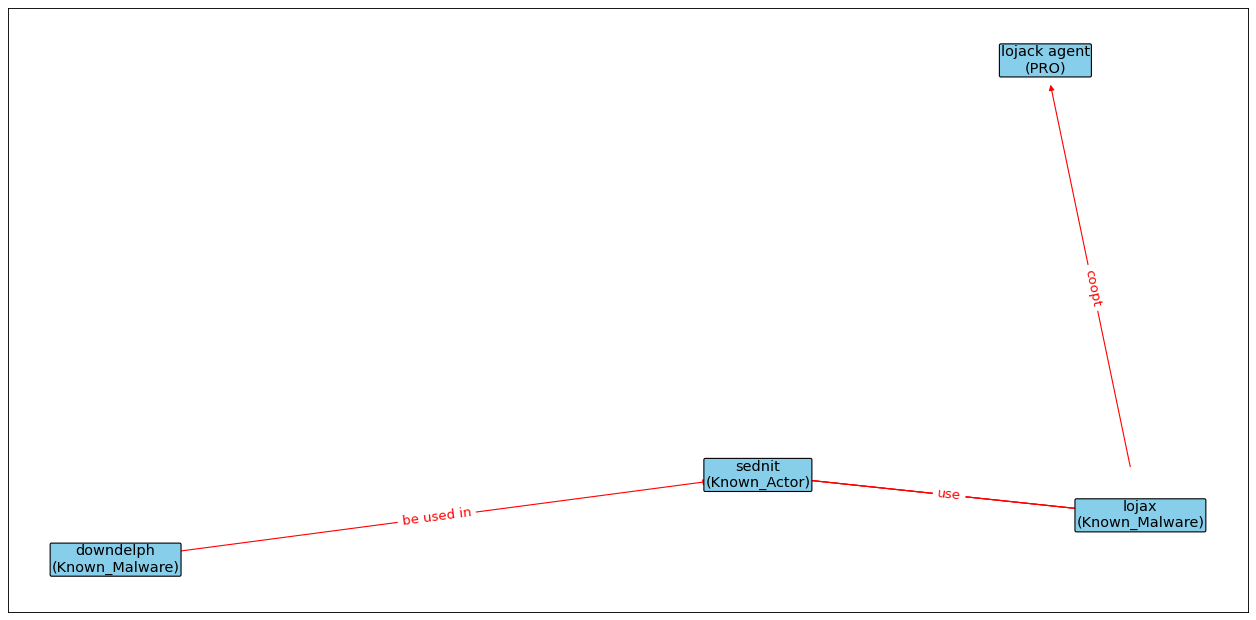

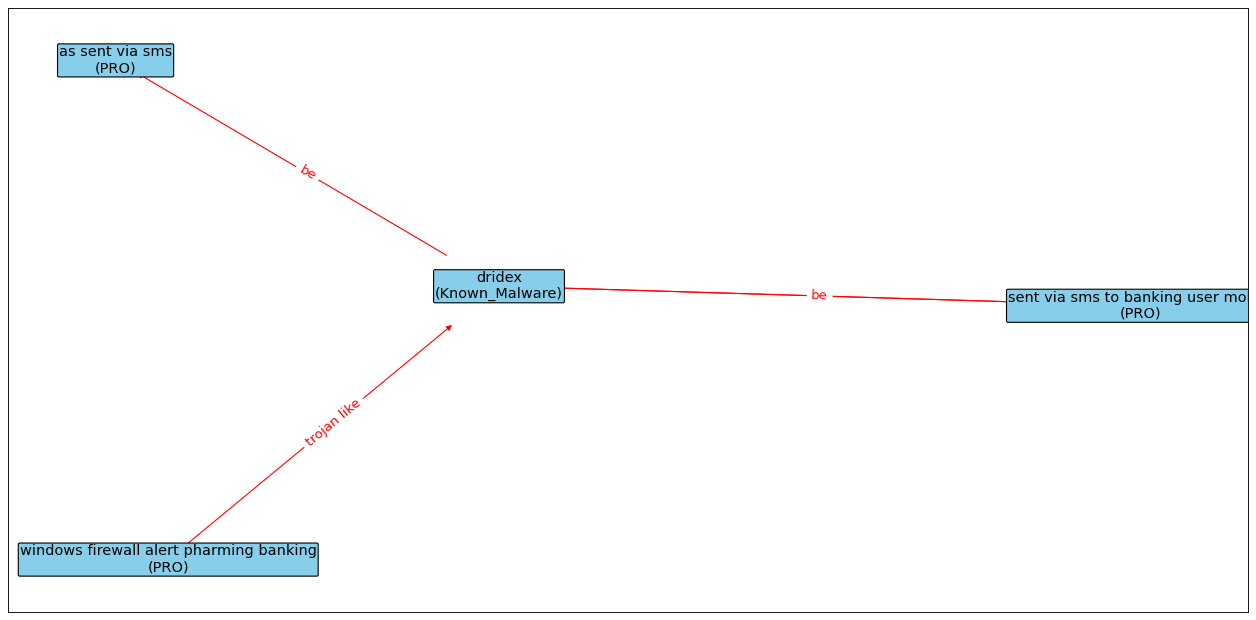

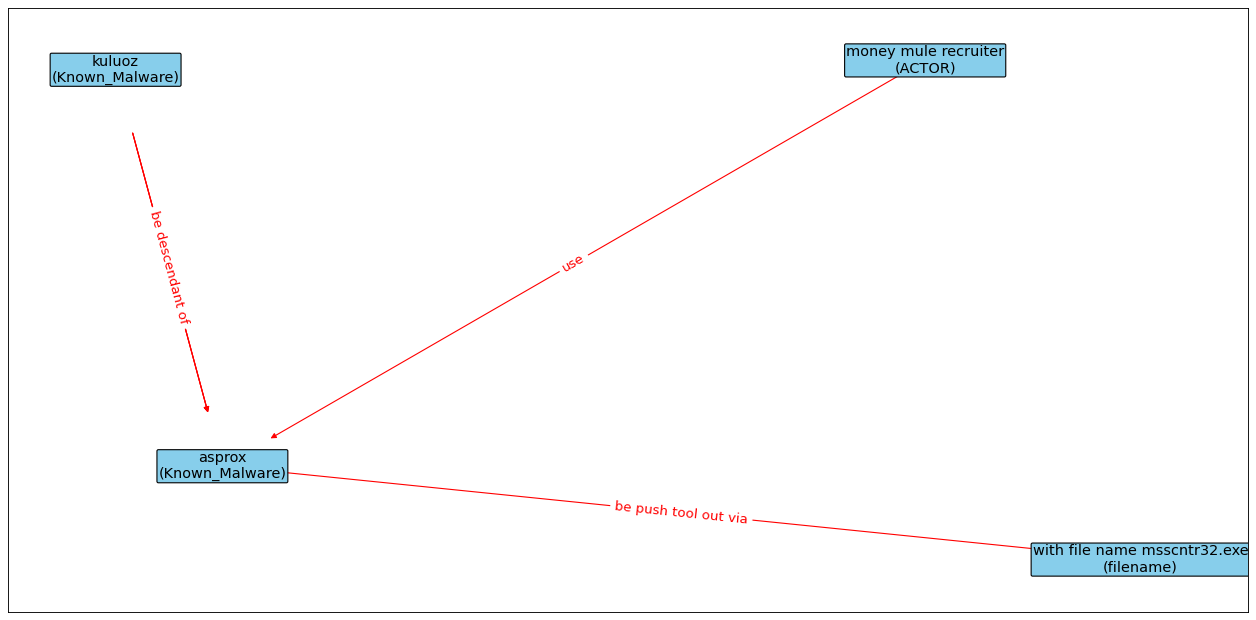

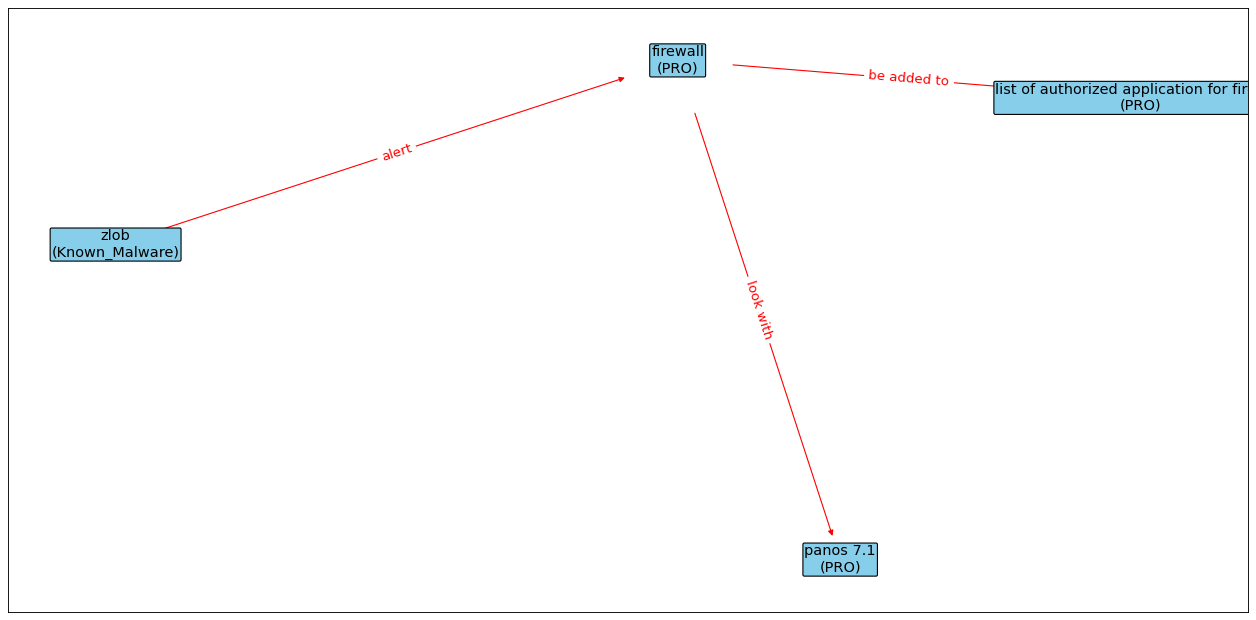

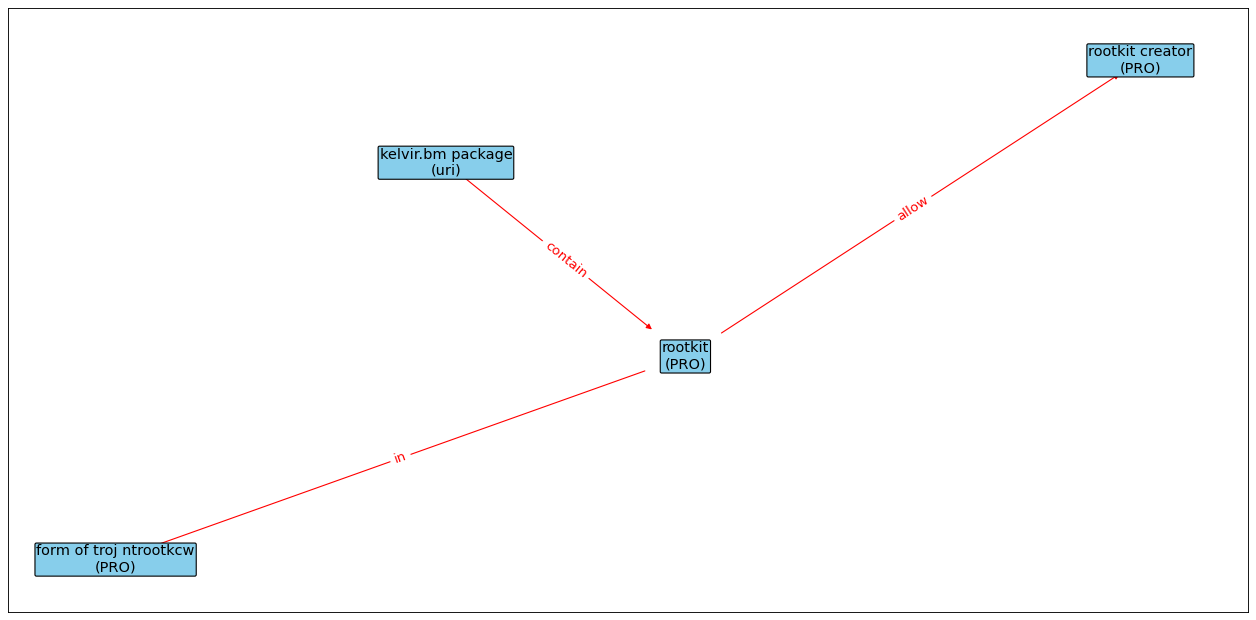

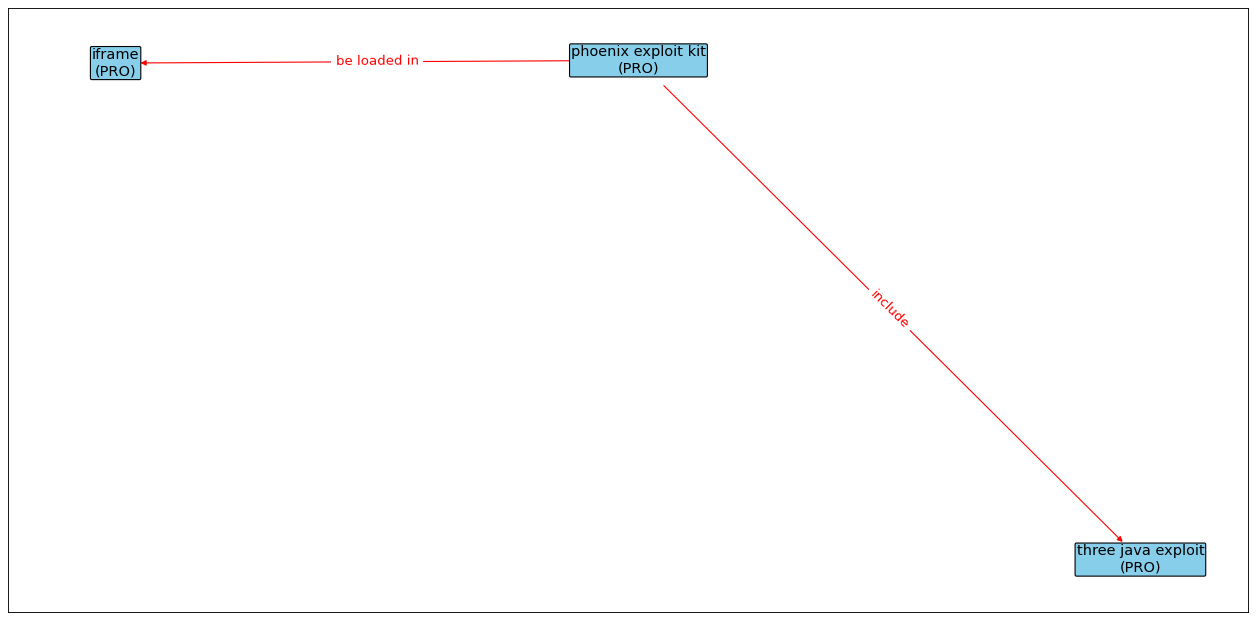

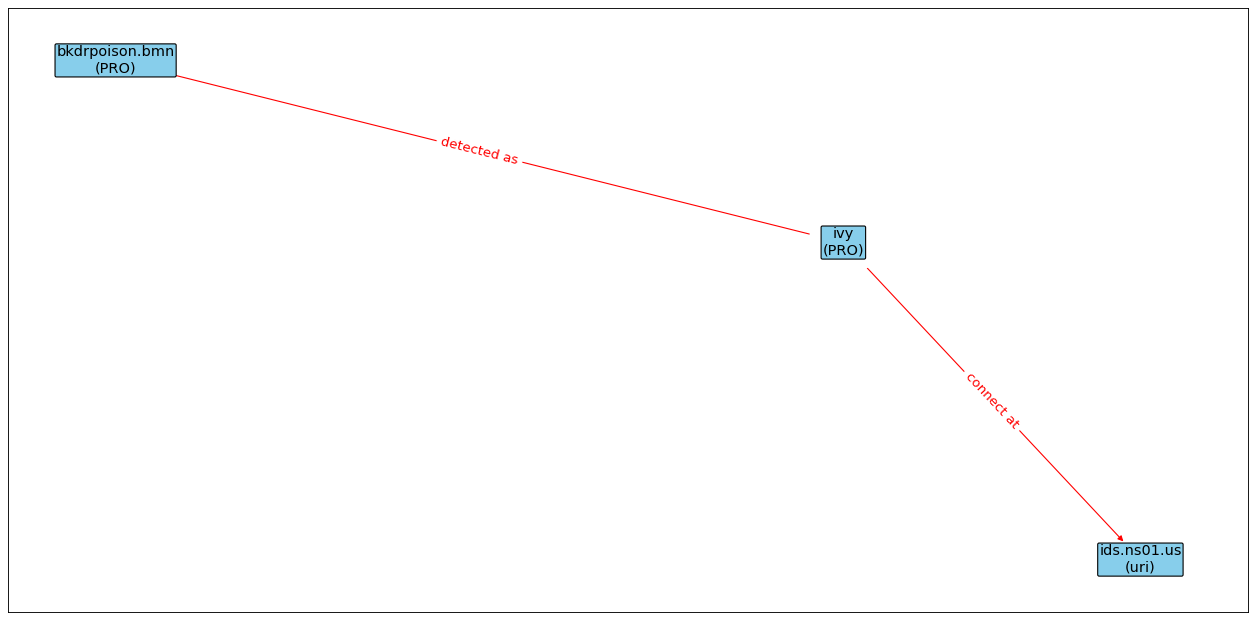

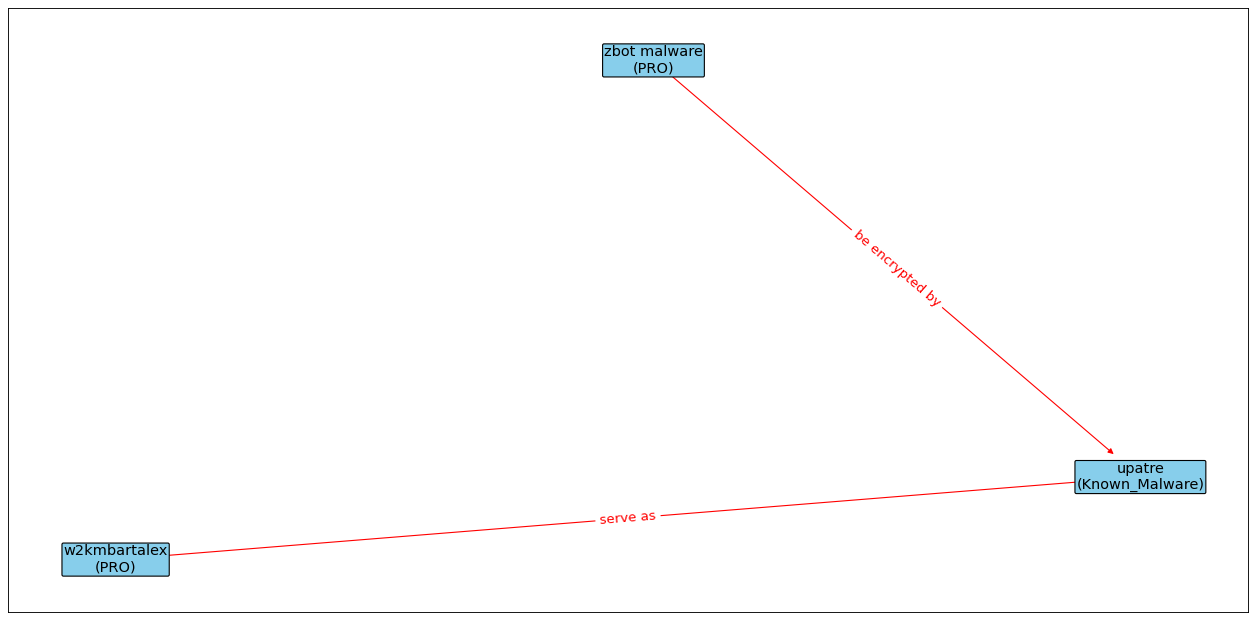

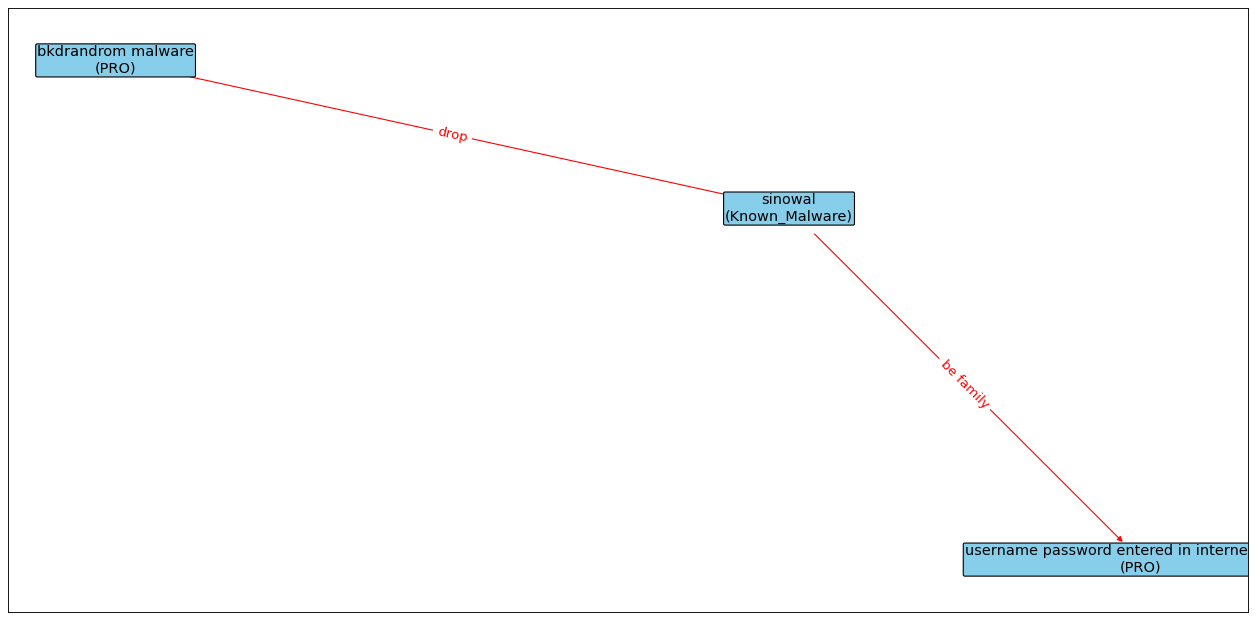

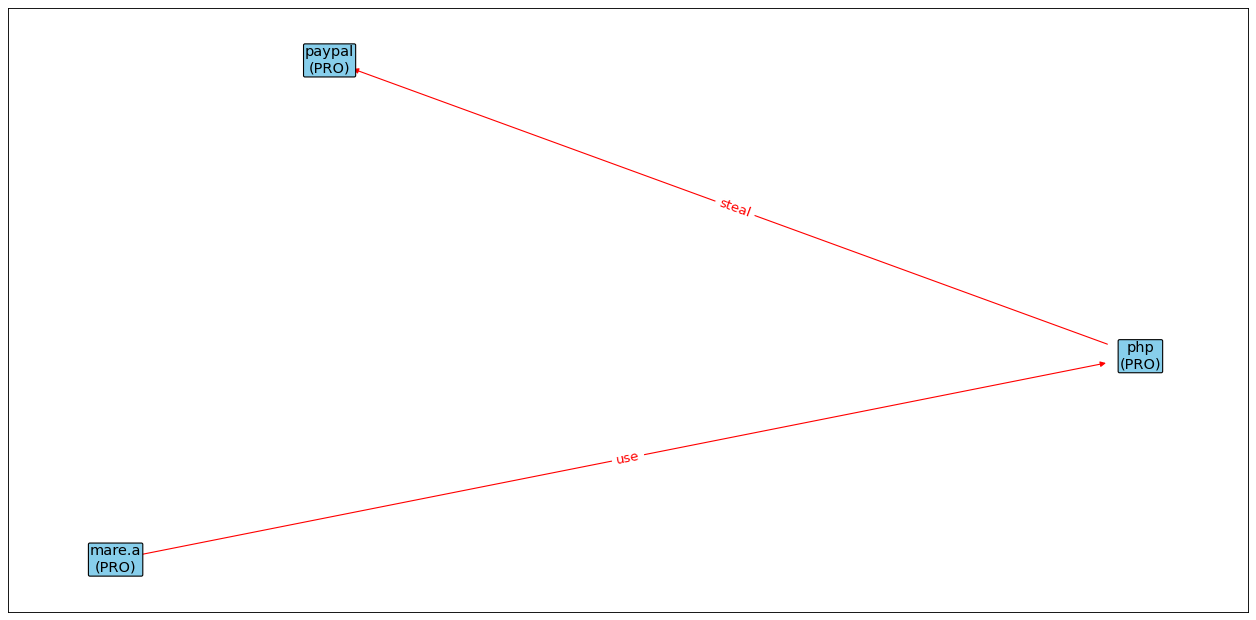

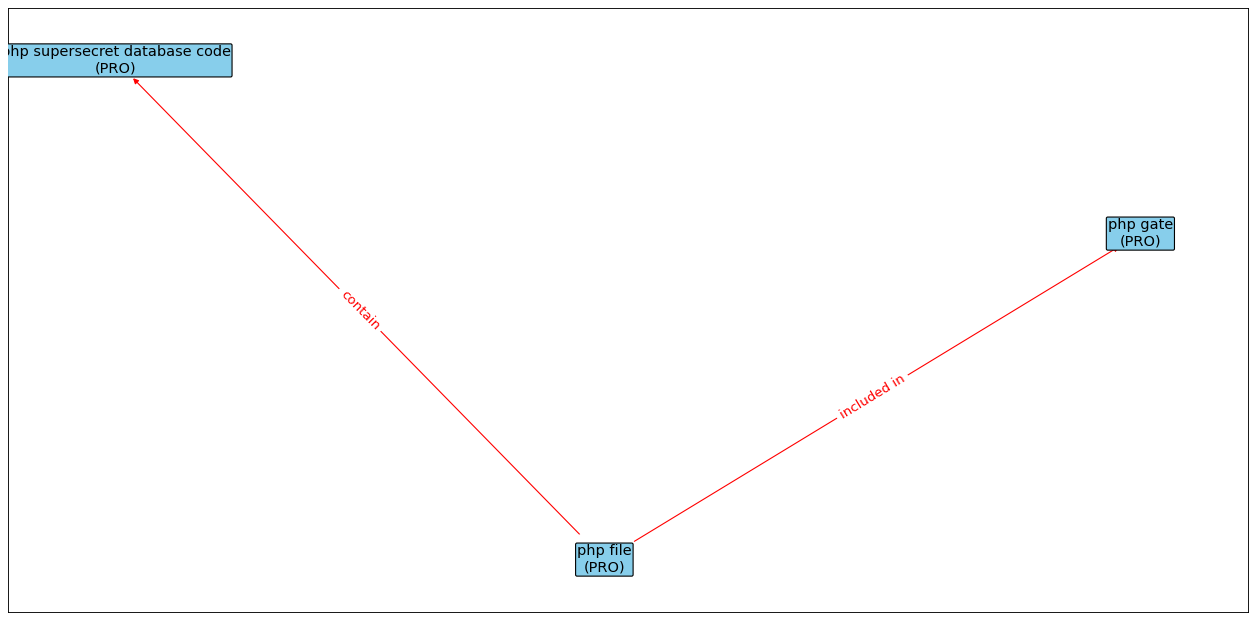

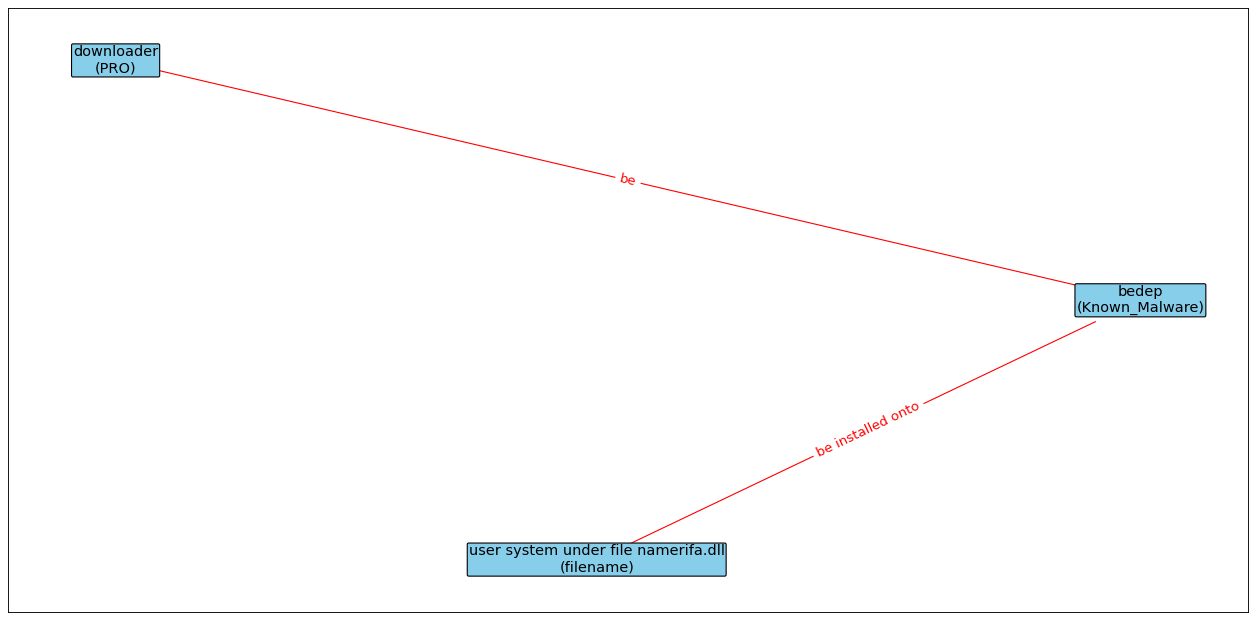

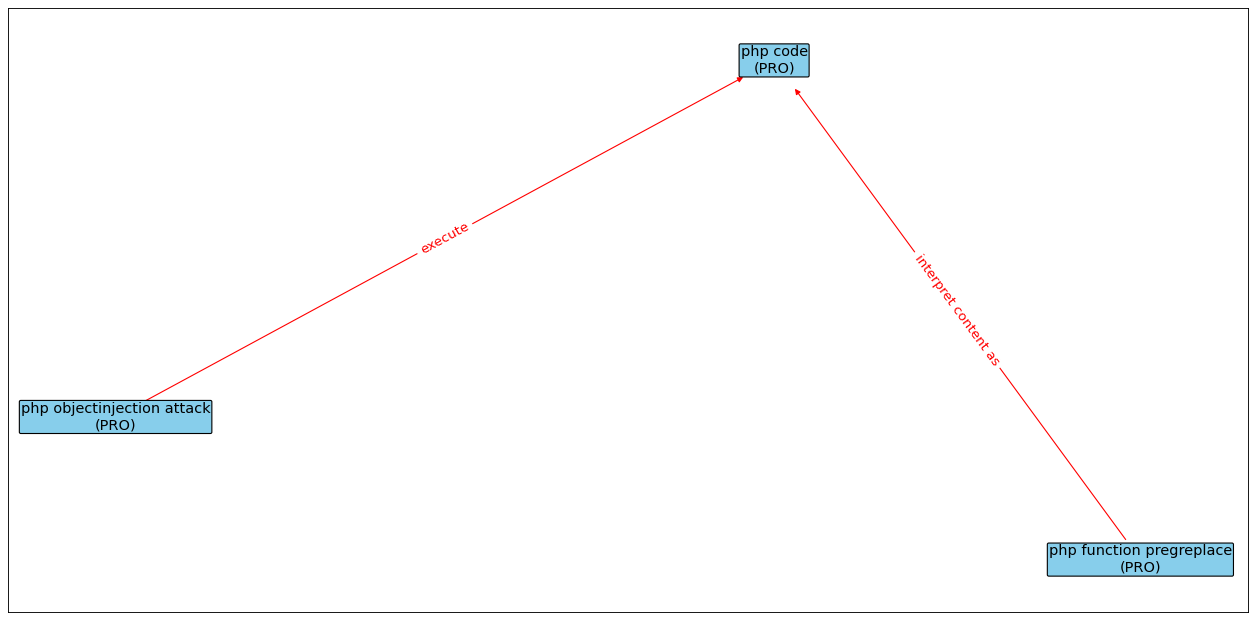

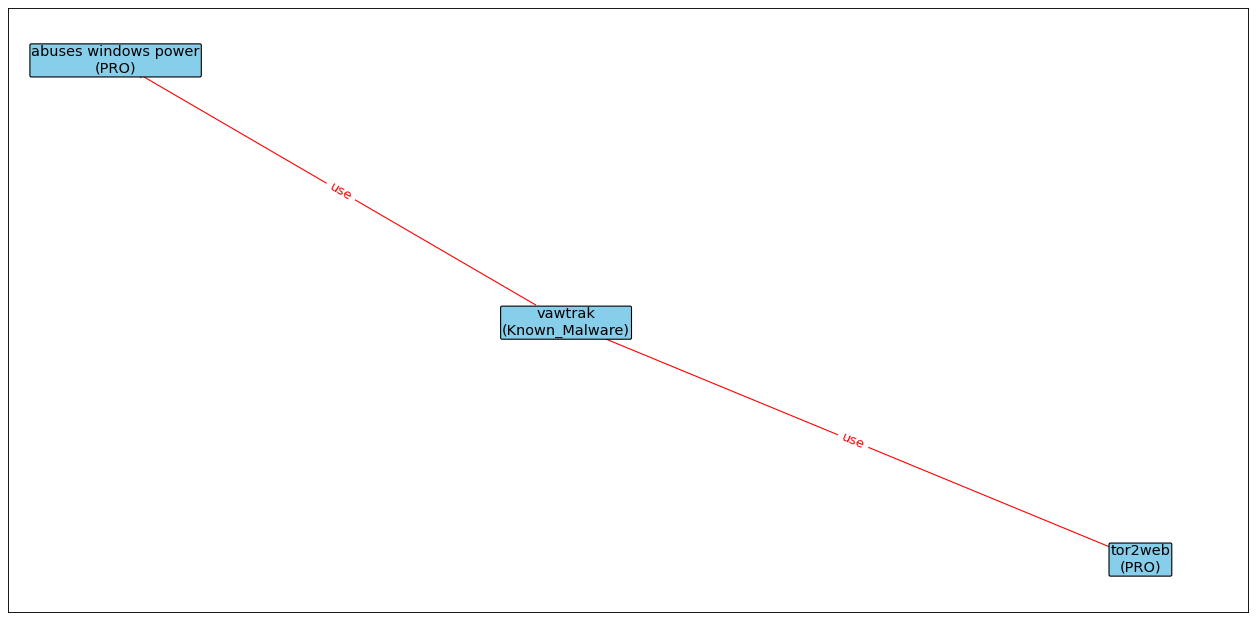

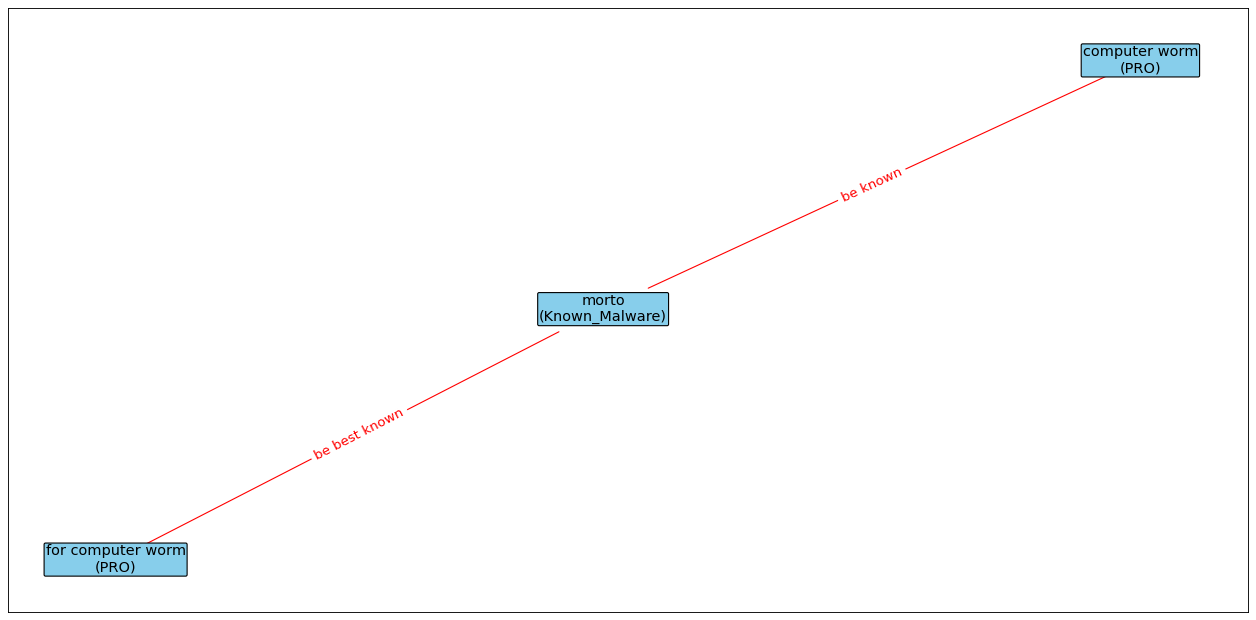

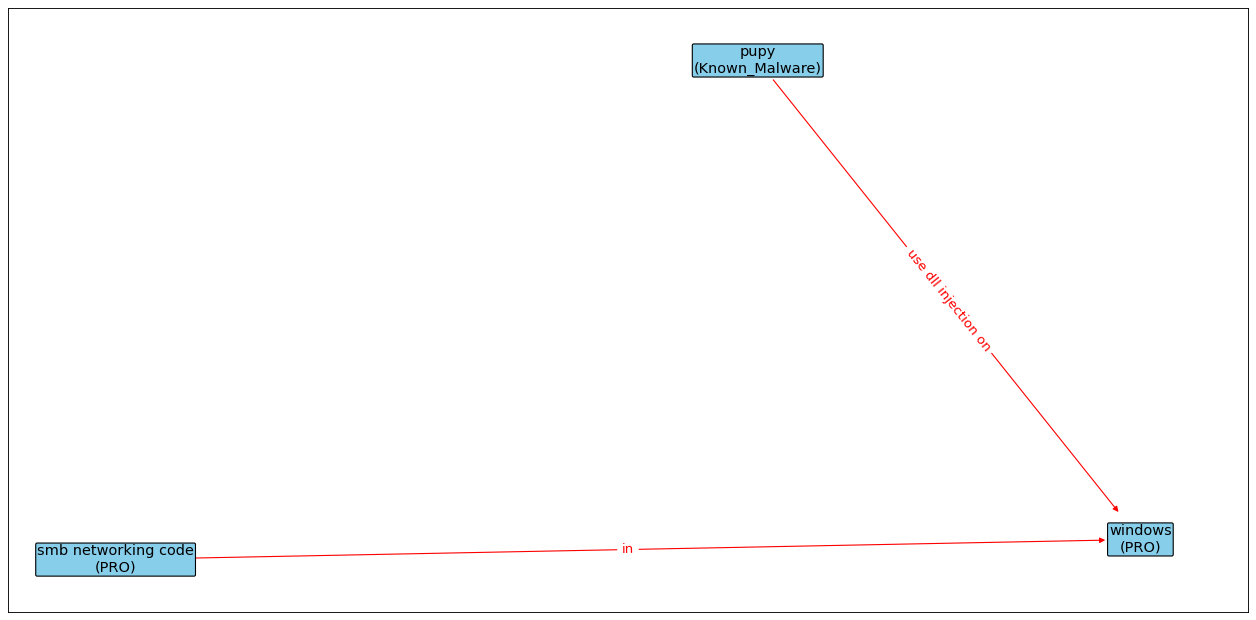

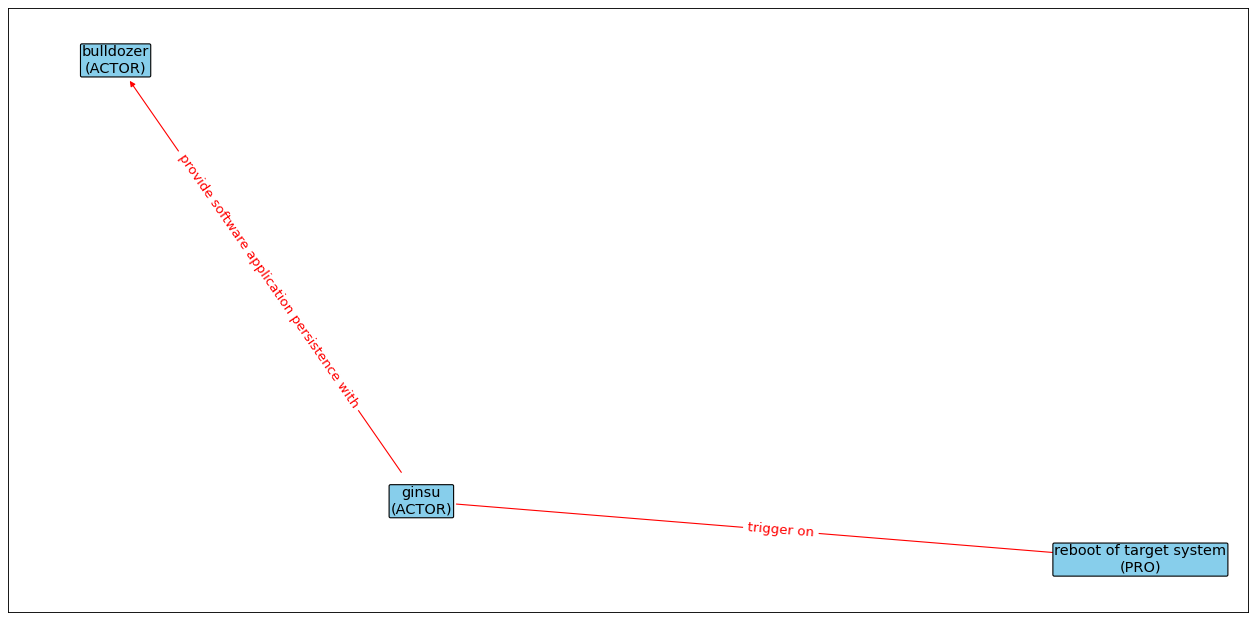

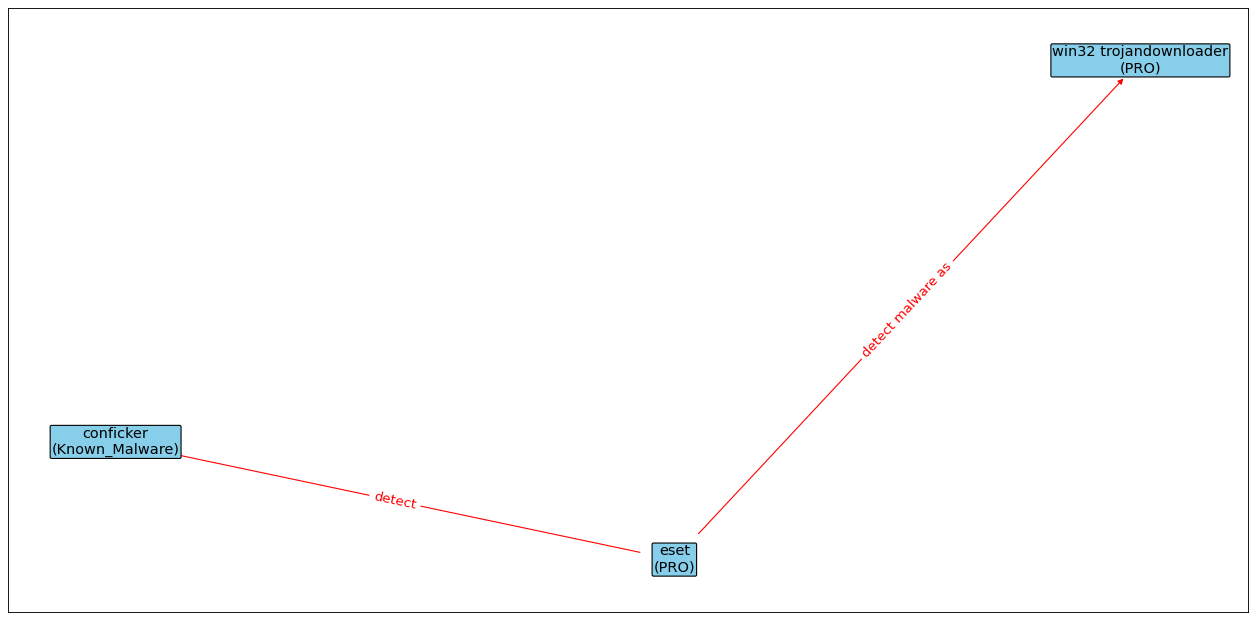

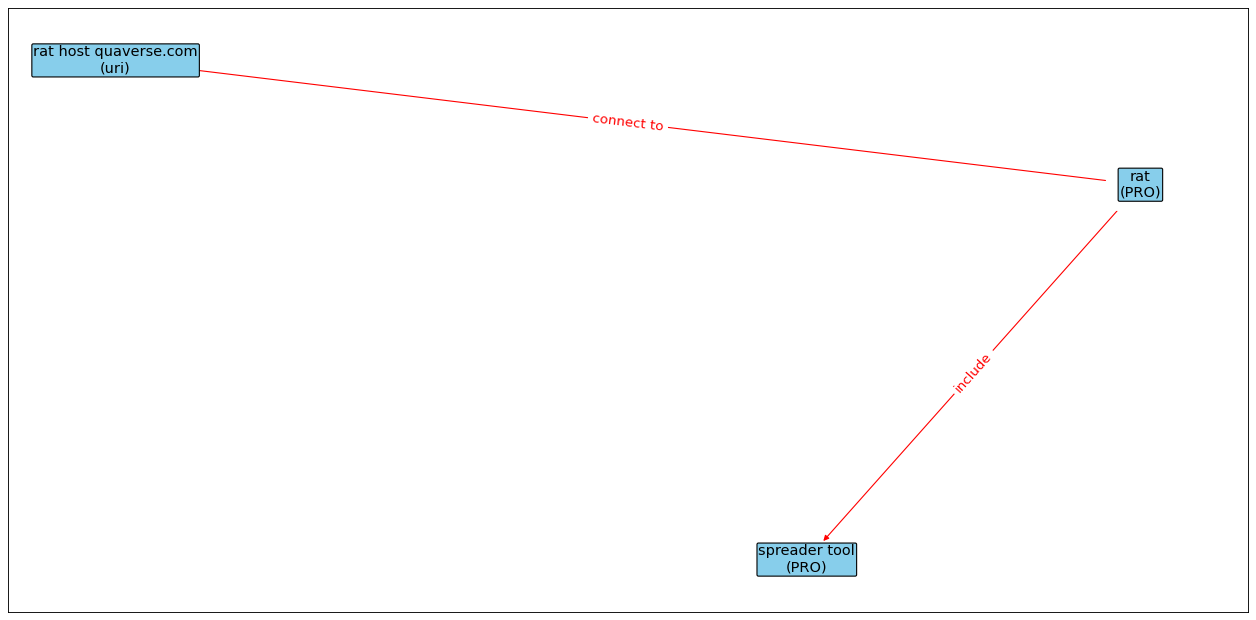

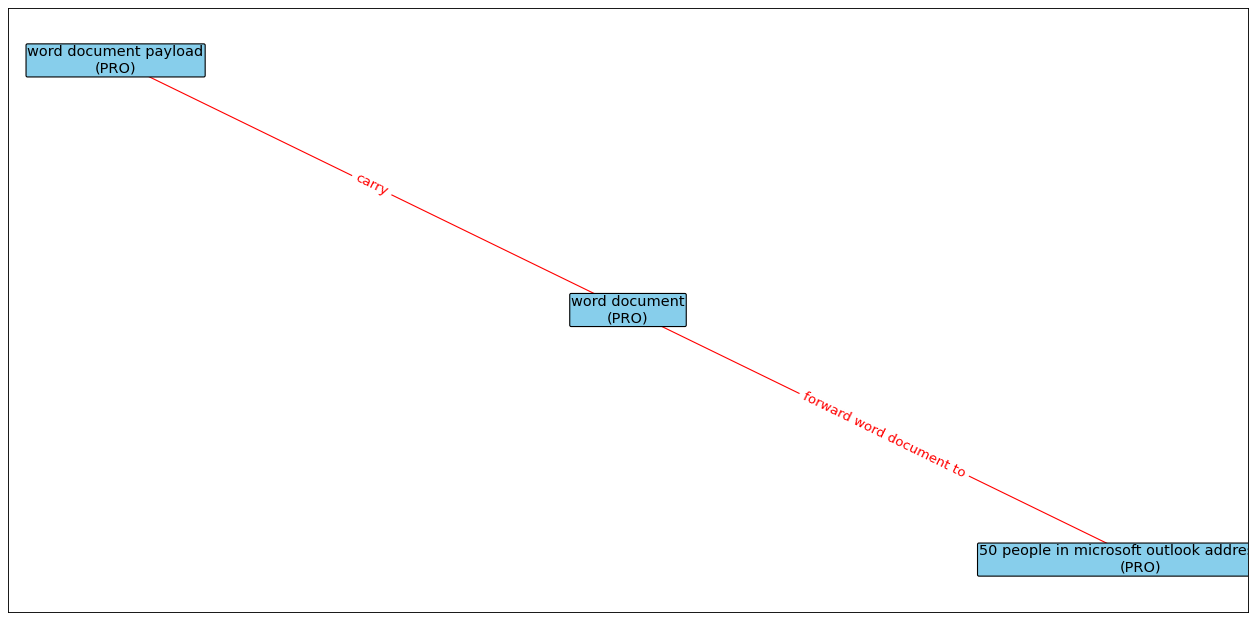

In [620]:
coms = algorithms.dcs(kg.to_undirected())
for com in coms.communities:
    sg, sg_tactics, sg_articles, sg_linking_nodes = extract_subgraph(kg, com)
    if len(sg.nodes) > 2 and len(sg_articles) > 1 and len(sg_tactics) > 0:
        draw_graph(sg, legend=False)
